<a href="https://colab.research.google.com/github/Hansamalee0630/Federated-Diabetes-Research/blob/component3/retinal2_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Binary Diabetic Retinopathy Detection - Preprocessing & Dataset Module
=======================================================================

This module provides preprocessing pipelines and PyTorch Dataset/DataLoader
utilities for binary classification of diabetic retinopathy from retinal
fundus images (EyePACS/Kaggle dataset).

Task: Binary classification at PATIENT level
    - Class 0: No diabetic retinopathy in BOTH eyes (both levels = 0)
    - Class 1: Diabetic retinopathy present in EITHER eye (any level >= 1)

Key Feature: Splits and balances data at the PATIENT level to prevent
data leakage between train/val/test sets.

Designed for use with EfficientNet and similar CNN architectures.
"""

import os
import random
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from typing import Tuple, Dict, Optional

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """
    Central configuration for paths, hyperparameters, and preprocessing settings.
    """
    # Paths
    DATA_DIR = "/content/drive/MyDrive/MULTIMODAL/datasets/EYEPACS/images/resized_train_cropped"
    LABELS_PATH = "/content/drive/MyDrive/MULTIMODAL/datasets/EYEPACS/trainLabels_cropped.csv"

    # Image settings
    IMAGE_SIZE = 224  # Standard input size for EfficientNet

    # Training settings
    BATCH_SIZE = 32
    NUM_WORKERS = 2

    # Reproducibility
    SEED = 42

    # Data split ratios
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15  # Fraction of remaining data after test split


def seed_everything(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across Python, NumPy, and PyTorch.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"[INFO] Random seed set to {seed}")


# ============================================================================
# PATIENT-LEVEL LABEL PROCESSING
# ============================================================================

def extract_patient_id(image_name: str) -> str:
    """
    Extract patient ID from image filename.

    Examples:
        "10_left"  → "10"
        "10_right" → "10"
        "1234_left" → "1234"

    Parameters
    ----------
    image_name : str
        Image filename without extension (e.g., "10_left").

    Returns
    -------
    str
        Patient ID.
    """
    # Split by underscore and take the first part (patient ID)
    return image_name.rsplit('_', 1)[0]


def extract_eye_side(image_name: str) -> str:
    """
    Extract eye side (left/right) from image filename.

    Parameters
    ----------
    image_name : str
        Image filename without extension (e.g., "10_left").

    Returns
    -------
    str
        Eye side ("left" or "right").
    """
    return image_name.rsplit('_', 1)[1]


def load_and_process_labels_patient_level(labels_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load labels and create patient-level binary labels.

    Patient-level binarization:
        - If BOTH eyes have level 0 → patient_label = 0 (No DR)
        - If EITHER eye has level >= 1 → patient_label = 1 (Has DR)

    Parameters
    ----------
    labels_path : str
        Path to trainLabels.csv file.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        - image_df: DataFrame with columns ['image', 'patient_id', 'eye', 'level', 'binary_label']
        - patient_df: DataFrame with columns ['patient_id', 'patient_label', 'left_level', 'right_level']
    """
    # Load original labels
    df = pd.read_csv(labels_path)

    print("=" * 60)
    print("LABEL PROCESSING (PATIENT-LEVEL)")
    print("=" * 60)
    print(f"\nTotal images: {len(df)}")

    # Display original 5-class distribution
    print("\nOriginal 5-class distribution (image level):")
    print(df['level'].value_counts().sort_index().to_string())

    # Extract patient ID and eye side
    df['patient_id'] = df['image'].apply(extract_patient_id)
    df['eye'] = df['image'].apply(extract_eye_side)

    # Create image-level binary label (for reference)
    df['binary_label'] = (df['level'] >= 1).astype(int)

    # Count unique patients
    n_patients = df['patient_id'].nunique()
    print(f"\nUnique patients: {n_patients}")

    # Create patient-level DataFrame
    # Pivot to get left and right eye levels for each patient
    patient_pivot = df.pivot_table(
        index='patient_id',
        columns='eye',
        values='level',
        aggfunc='first'
    ).reset_index()

    # Rename columns
    patient_pivot.columns.name = None
    patient_pivot = patient_pivot.rename(columns={
        'left': 'left_level',
        'right': 'right_level'
    })

    # Handle patients with only one eye image
    patient_pivot['left_level'] = patient_pivot['left_level'].fillna(-1).astype(int)
    patient_pivot['right_level'] = patient_pivot['right_level'].fillna(-1).astype(int)

    # Compute patient-level label
    # Patient has DR if EITHER eye has level >= 1
    def compute_patient_label(row):
        left = row['left_level'] if row['left_level'] >= 0 else 0
        right = row['right_level'] if row['right_level'] >= 0 else 0
        # If either eye has DR (level >= 1), patient label is 1
        return 1 if (left >= 1 or right >= 1) else 0

    patient_pivot['patient_label'] = patient_pivot.apply(compute_patient_label, axis=1)

    # Display patient-level statistics
    print("\n" + "-" * 40)
    print("PATIENT-LEVEL STATISTICS")
    print("-" * 40)

    patient_counts = patient_pivot['patient_label'].value_counts().sort_index()
    print(f"\nPatient-level binary distribution:")
    print(f"  Class 0 (No DR in either eye):  {patient_counts[0]:,} ({100*patient_counts[0]/n_patients:.1f}%)")
    print(f"  Class 1 (DR in at least one eye): {patient_counts[1]:,} ({100*patient_counts[1]/n_patients:.1f}%)")

    # Merge patient label back to image DataFrame
    df = df.merge(
        patient_pivot[['patient_id', 'patient_label']],
        on='patient_id',
        how='left'
    )

    # Show examples
    print("\n" + "-" * 40)
    print("SAMPLE PATIENT DATA")
    print("-" * 40)
    sample_patients = patient_pivot.head(10)
    print(sample_patients.to_string(index=False))

    print("\n" + "=" * 60)

    image_df = df[['image', 'patient_id', 'eye', 'level', 'binary_label', 'patient_label']]
    patient_df = patient_pivot

    return image_df, patient_df


# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def crop_black(img: np.ndarray, tolerance: int = 7) -> np.ndarray:
    """
    Remove black borders from retinal fundus images.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tolerance
    coords = np.argwhere(mask)

    if coords.size == 0:
        return img

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    cropped = img[y_min:y_max+1, x_min:x_max+1]

    return cropped


def apply_clahe(img: np.ndarray, clip_limit: float = 2.0,
                tile_grid_size: Tuple[int, int] = (8, 8)) -> np.ndarray:
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE).
    """
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return enhanced


def apply_ben_graham(img: np.ndarray, sigma: int = 10) -> np.ndarray:
    """
    Apply Ben Graham's preprocessing (unsharp masking variant).
    """
    blurred = cv2.GaussianBlur(img, (0, 0), sigma)
    enhanced = cv2.addWeighted(img, 4, blurred, -4, 128)
    return enhanced


def circle_crop(img: np.ndarray) -> np.ndarray:
    """
    Apply a circular mask centered on the image.
    """
    height, width = img.shape[:2]
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y)

    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, thickness=-1)
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img


def preprocess_image(
    path: str,
    image_size: int = 224,
    use_clahe: bool = True,
    use_circle_crop: bool = True
) -> Optional[torch.Tensor]:
    """
    Complete preprocessing pipeline for a single retinal image.
    """
    img = cv2.imread(path)
    if img is None:
        print(f"[WARNING] Could not load image: {path}")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_black(img, tolerance=7)
    img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)

    if use_clahe:
        img = apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8))
    else:
        img = apply_ben_graham(img, sigma=10)

    if use_circle_crop:
        img = circle_crop(img)
        img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)

    img = img.astype(np.float32) / 255.0
    tensor = torch.from_numpy(img).permute(2, 0, 1)

    return tensor


# ============================================================================
# DATA AUGMENTATION TRANSFORMS
# ============================================================================

def get_train_transform() -> transforms.Compose:
    """
    Get augmentation transforms for training data.
    """
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


def get_val_test_transform() -> transforms.Compose:
    """
    Get transforms for validation and test data.
    """
    return transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


# ============================================================================
# DATASET CLASS
# ============================================================================

class BinaryRetinalDataset(Dataset):
    """
    PyTorch Dataset for binary diabetic retinopathy classification.

    Uses PATIENT-LEVEL labels: if either eye has DR, both eye images
    are labeled as positive (1).
    """

    def __init__(
        self,
        df: pd.DataFrame,
        directory: str,
        is_training: bool = True,
        use_clahe: bool = True,
        use_circle_crop: bool = True,
        image_size: int = 224
    ):
        self.df = df.reset_index(drop=True)
        self.directory = directory
        self.is_training = is_training
        self.use_clahe = use_clahe
        self.use_circle_crop = use_circle_crop
        self.image_size = image_size

        if is_training:
            self.transform = get_train_transform()
        else:
            self.transform = get_val_test_transform()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        img_name = row['image'] + ".jpeg"
        img_path = os.path.join(self.directory, img_name)

        # Use PATIENT-LEVEL label
        label = row['patient_label']

        image = preprocess_image(
            path=img_path,
            image_size=self.image_size,
            use_clahe=self.use_clahe,
            use_circle_crop=self.use_circle_crop
        )

        if image is None:
            print(f"[WARNING] Returning zero tensor for index {idx}")
            image = torch.zeros(3, self.image_size, self.image_size, dtype=torch.float32)

        image = self.transform(image)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return {
            'image': image,
            'label': label_tensor
        }


# ============================================================================
# PATIENT-LEVEL SPLITTING AND BALANCING
# ============================================================================

def split_patients(
    patient_df: pd.DataFrame,
    test_size: float = 0.15,
    val_size: float = 0.15,
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split patients into train, validation, and test sets with stratification.

    This ensures that both eyes of the same patient are in the same split,
    preventing data leakage.

    Parameters
    ----------
    patient_df : pd.DataFrame
        Patient-level DataFrame with 'patient_id' and 'patient_label'.
    test_size : float
        Fraction of patients for test set.
    val_size : float
        Fraction of remaining patients for validation.
    seed : int
        Random seed.

    Returns
    -------
    Tuple
        (train_patients, val_patients, test_patients) DataFrames
    """
    # First split: separate test set
    train_val_patients, test_patients = train_test_split(
        patient_df,
        test_size=test_size,
        stratify=patient_df['patient_label'],
        random_state=seed
    )

    # Second split: separate validation from training
    adjusted_val_size = val_size / (1 - test_size)
    train_patients, val_patients = train_test_split(
        train_val_patients,
        test_size=adjusted_val_size,
        stratify=train_val_patients['patient_label'],
        random_state=seed
    )

    return train_patients, val_patients, test_patients


def balance_patients(
    patient_df: pd.DataFrame,
    strategy: str = 'undersample',
    target_per_class: int = None,
    seed: int = 42
) -> pd.DataFrame:
    """
    Balance patients by class.

    Parameters
    ----------
    patient_df : pd.DataFrame
        Patient-level DataFrame with 'patient_label'.
    strategy : str
        'undersample' - reduce majority to match minority
        'oversample'  - increase minority to match majority
        'custom'      - use target_per_class for both
    target_per_class : int
        Number of patients per class (for 'custom' strategy).
    seed : int
        Random seed.

    Returns
    -------
    pd.DataFrame
        Balanced patient DataFrame.
    """
    class_0 = patient_df[patient_df['patient_label'] == 0]
    class_1 = patient_df[patient_df['patient_label'] == 1]

    print(f"\n  Before balancing:")
    print(f"    Class 0 patients: {len(class_0)}")
    print(f"    Class 1 patients: {len(class_1)}")

    if strategy == 'undersample':
        n_samples = min(len(class_0), len(class_1))
        class_0_balanced = resample(class_0, replace=False, n_samples=n_samples, random_state=seed)
        class_1_balanced = resample(class_1, replace=False, n_samples=n_samples, random_state=seed)

    elif strategy == 'oversample':
        n_samples = max(len(class_0), len(class_1))
        class_0_balanced = resample(class_0, replace=True, n_samples=n_samples, random_state=seed)
        class_1_balanced = resample(class_1, replace=True, n_samples=n_samples, random_state=seed)

    elif strategy == 'custom':
        if target_per_class is None:
            raise ValueError("target_per_class required for 'custom' strategy")
        class_0_balanced = resample(class_0, replace=(len(class_0) < target_per_class),
                                     n_samples=target_per_class, random_state=seed)
        class_1_balanced = resample(class_1, replace=(len(class_1) < target_per_class),
                                     n_samples=target_per_class, random_state=seed)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    balanced = pd.concat([class_0_balanced, class_1_balanced])
    balanced = balanced.sample(frac=1, random_state=seed).reset_index(drop=True)

    print(f"\n  After balancing ({strategy}):")
    print(f"    Class 0 patients: {len(class_0_balanced)}")
    print(f"    Class 1 patients: {len(class_1_balanced)}")
    print(f"    Total patients:   {len(balanced)}")

    return balanced


def expand_patients_to_images(
    patient_df: pd.DataFrame,
    image_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Expand patient-level DataFrame back to image-level by joining with image data.

    Parameters
    ----------
    patient_df : pd.DataFrame
        Patient-level DataFrame with 'patient_id'.
    image_df : pd.DataFrame
        Full image-level DataFrame with 'patient_id', 'image', etc.

    Returns
    -------
    pd.DataFrame
        Image-level DataFrame for the selected patients.
    """
    selected_patient_ids = patient_df['patient_id'].unique()
    expanded = image_df[image_df['patient_id'].isin(selected_patient_ids)].copy()
    return expanded


def print_split_statistics_patient_level(
    train_images: pd.DataFrame,
    val_images: pd.DataFrame,
    test_images: pd.DataFrame,
    train_patients: pd.DataFrame,
    val_patients: pd.DataFrame,
    test_patients: pd.DataFrame
) -> None:
    """
    Print statistics for patient-level splits.
    """
    print("\n" + "=" * 60)
    print("FINAL SPLIT STATISTICS (PATIENT-LEVEL)")
    print("=" * 60)

    splits = [
        ("Train", train_images, train_patients),
        ("Val", val_images, val_patients),
        ("Test", test_images, test_patients)
    ]

    for name, img_df, pat_df in splits:
        n_patients = len(pat_df)
        n_images = len(img_df)

        p_class_0 = (pat_df['patient_label'] == 0).sum()
        p_class_1 = (pat_df['patient_label'] == 1).sum()

        i_class_0 = (img_df['patient_label'] == 0).sum()
        i_class_1 = (img_df['patient_label'] == 1).sum()

        balanced_tag = "(BALANCED)" if name == "Train" else "(natural)"

        print(f"\n{name} Set {balanced_tag}:")
        print(f"  Patients: {n_patients:,}")
        print(f"    Class 0: {p_class_0:,} ({100*p_class_0/n_patients:.1f}%)")
        print(f"    Class 1: {p_class_1:,} ({100*p_class_1/n_patients:.1f}%)")
        print(f"  Images: {n_images:,}")
        print(f"    Class 0: {i_class_0:,} ({100*i_class_0/n_images:.1f}%)")
        print(f"    Class 1: {i_class_1:,} ({100*i_class_1/n_images:.1f}%)")

    print("\n" + "=" * 60)


# ============================================================================
# MAIN DATA LOADER CREATION
# ============================================================================

def create_datasets_and_loaders(
    image_df: pd.DataFrame,
    patient_df: pd.DataFrame,
    config: Config,
    use_clahe: bool = True,
    use_circle_crop: bool = True,
    balance_train: bool = True,
    balance_strategy: str = 'undersample'
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create train, validation, and test DataLoaders with patient-level splitting
    and optional training set balancing.

    Parameters
    ----------
    image_df : pd.DataFrame
        Image-level DataFrame from load_and_process_labels_patient_level().
    patient_df : pd.DataFrame
        Patient-level DataFrame from load_and_process_labels_patient_level().
    config : Config
        Configuration object.
    use_clahe : bool
        If True, use CLAHE. If False, use Ben Graham.
    use_circle_crop : bool
        If True, apply circular crop.
    balance_train : bool
        If True, balance training patients.
    balance_strategy : str
        'undersample', 'oversample', or 'custom'.

    Returns
    -------
    Tuple
        (train_loader, val_loader, test_loader)
    """
    print("\n" + "=" * 60)
    print("CREATING PATIENT-LEVEL SPLITS")
    print("=" * 60)

    # Step 1: Split PATIENTS (not images)
    train_patients, val_patients, test_patients = split_patients(
        patient_df=patient_df,
        test_size=config.TEST_SIZE,
        val_size=config.VAL_SIZE,
        seed=config.SEED
    )

    print(f"\nPatient split:")
    print(f"  Train patients: {len(train_patients)}")
    print(f"  Val patients:   {len(val_patients)}")
    print(f"  Test patients:  {len(test_patients)}")

    # Step 2: Balance TRAINING patients only
    if balance_train:
        print("\n" + "-" * 40)
        print("BALANCING TRAINING PATIENTS")
        print("-" * 40)
        train_patients = balance_patients(
            patient_df=train_patients,
            strategy=balance_strategy,
            seed=config.SEED
        )

    # Step 3: Expand patients back to images
    train_images = expand_patients_to_images(train_patients, image_df)
    val_images = expand_patients_to_images(val_patients, image_df)
    test_images = expand_patients_to_images(test_patients, image_df)

    # Print final statistics
    print_split_statistics_patient_level(
        train_images, val_images, test_images,
        train_patients, val_patients, test_patients
    )

    # Step 4: Create datasets
    train_dataset = BinaryRetinalDataset(
        df=train_images,
        directory=config.DATA_DIR,
        is_training=True,
        use_clahe=use_clahe,
        use_circle_crop=use_circle_crop,
        image_size=config.IMAGE_SIZE
    )

    val_dataset = BinaryRetinalDataset(
        df=val_images,
        directory=config.DATA_DIR,
        is_training=False,
        use_clahe=use_clahe,
        use_circle_crop=use_circle_crop,
        image_size=config.IMAGE_SIZE
    )

    test_dataset = BinaryRetinalDataset(
        df=test_images,
        directory=config.DATA_DIR,
        is_training=False,
        use_clahe=use_clahe,
        use_circle_crop=use_circle_crop,
        image_size=config.IMAGE_SIZE
    )

    # Step 5: Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    print(f"\nDataLoaders created:")
    print(f"  Train: {len(train_loader)} batches, {len(train_dataset)} images")
    print(f"  Val:   {len(val_loader)} batches, {len(val_dataset)} images")
    print(f"  Test:  {len(test_loader)} batches, {len(test_dataset)} images")

    return train_loader, val_loader, test_loader


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    """
    Demonstration of patient-level preprocessing and dataset pipeline.

    This module handles eye pairs (left/right) from the same patient:

    1. **Patient-Level Labels**: A patient is labeled as positive (1) if
       EITHER eye has DR (level >= 1), ensuring clinical relevance.

    2. **Patient-Level Splitting**: Both eyes of a patient stay in the same
       split (train/val/test), preventing data leakage.

    3. **Patient-Level Balancing**: Balancing is done at the patient level,
       then expanded back to images for training.
    """

    # Initialize
    config = Config()
    seed_everything(config.SEED)

    # Load and process labels at patient level
    image_df, patient_df = load_and_process_labels_patient_level(config.LABELS_PATH)

    # Create datasets and loaders with patient-level handling
    train_loader, val_loader, test_loader = create_datasets_and_loaders(
        image_df=image_df,
        patient_df=patient_df,
        config=config,
        use_clahe=True,
        use_circle_crop=True,
        balance_train=True,
        balance_strategy='undersample'
    )

    # Verify a sample batch
    print("\n" + "=" * 60)
    print("SAMPLE BATCH VERIFICATION")
    print("=" * 60)

    sample_batch = next(iter(train_loader))
    print(f"\nBatch image shape: {sample_batch['image'].shape}")
    print(f"Batch label shape: {sample_batch['label'].shape}")
    print(f"Image dtype: {sample_batch['image'].dtype}")
    print(f"Label dtype: {sample_batch['label'].dtype}")
    print(f"Image value range: [{sample_batch['image'].min():.3f}, {sample_batch['image'].max():.3f}]")
    print(f"Labels in batch: {sample_batch['label'].tolist()}")

    print("\n[SUCCESS] Patient-level preprocessing pipeline ready for training!")

[INFO] Random seed set to 42
LABEL PROCESSING (PATIENT-LEVEL)

Total images: 35108

Original 5-class distribution (image level):
level
0    25802
1     2438
2     5288
3      872
4      708

Unique patients: 17561

----------------------------------------
PATIENT-LEVEL STATISTICS
----------------------------------------

Patient-level binary distribution:
  Class 0 (No DR in either eye):  12,155 (69.2%)
  Class 1 (DR in at least one eye): 5,406 (30.8%)

----------------------------------------
SAMPLE PATIENT DATA
----------------------------------------
patient_id  left_level  right_level  patient_label
        10           0            0              0
       100           0            0              0
      1000           0            0              0
     10003           0            0              0
     10007           0            0              0
     10009           0            0              0
     10010           0            0              0
     10013           0          

[INFO] Data loaders found from previous cell.
MODEL INITIALIZATION
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s] 



Model: efficientnet_b0
Pretrained: True
Feature dimension: 1280
Total parameters: 4,336,253
Trainable parameters: 4,336,253
Device: cuda

TRAINING STARTED
Epochs: 25
Learning Rate: 0.0001
Scheduler: cosine
Early Stopping Patience: 7


Epoch 1/25
----------------------------------------


Train | Loss: 0.7578 | Acc: 0.5863 | AUC: 0.6261
Val   | Loss: 0.6102 | Acc: 0.6924 | AUC: 0.6702
      | Precision: 0.5003 | Recall: 0.4454 | F1: 0.4713
LR: 1.00e-04
✓ Best model saved! (AUC: 0.6702)

Epoch 2/25
----------------------------------------


Train | Loss: 0.6641 | Acc: 0.6382 | AUC: 0.6952
Val   | Loss: 0.6170 | Acc: 0.6824 | AUC: 0.7131
      | Precision: 0.4862 | Recall: 0.5657 | F1: 0.5230
LR: 9.05e-05
✓ Best model saved! (AUC: 0.7131)

Epoch 3/25
----------------------------------------


Train | Loss: 0.6199 | Acc: 0.6629 | AUC: 0.7278
Val   | Loss: 0.5766 | Acc: 0.7070 | AUC: 0.7270
      | Precision: 0.5239 | Recall: 0.5281 | F1: 0.5260
LR: 6.55e-05
✓ Best model saved! (AUC: 0.7270)

Epoch 4/25
----------------------------------------


Train | Loss: 0.5825 | Acc: 0.6925 | AUC: 0.7574
Val   | Loss: 0.5691 | Acc: 0.7144 | AUC: 0.7263
      | Precision: 0.5359 | Recall: 0.5386 | F1: 0.5372
LR: 3.45e-05

Epoch 5/25
----------------------------------------


Train | Loss: 0.5668 | Acc: 0.7023 | AUC: 0.7730
Val   | Loss: 0.5804 | Acc: 0.7000 | AUC: 0.7305
      | Precision: 0.5114 | Recall: 0.5694 | F1: 0.5388
LR: 9.55e-06
✓ Best model saved! (AUC: 0.7305)

Epoch 6/25
----------------------------------------


Train | Loss: 0.5793 | Acc: 0.6980 | AUC: 0.7625
Val   | Loss: 0.5604 | Acc: 0.7143 | AUC: 0.7298
      | Precision: 0.5361 | Recall: 0.5318 | F1: 0.5339
LR: 1.00e-04

Epoch 7/25
----------------------------------------


Train | Loss: 0.5558 | Acc: 0.7101 | AUC: 0.7831
Val   | Loss: 0.5658 | Acc: 0.7112 | AUC: 0.7453
      | Precision: 0.5290 | Recall: 0.5620 | F1: 0.5450
LR: 9.76e-05
✓ Best model saved! (AUC: 0.7453)

Epoch 8/25
----------------------------------------


Train | Loss: 0.5283 | Acc: 0.7299 | AUC: 0.8072
Val   | Loss: 0.5473 | Acc: 0.7203 | AUC: 0.7540
      | Precision: 0.5430 | Recall: 0.5768 | F1: 0.5594
LR: 9.05e-05
✓ Best model saved! (AUC: 0.7540)

Epoch 9/25
----------------------------------------


Train | Loss: 0.5002 | Acc: 0.7479 | AUC: 0.8291
Val   | Loss: 0.5407 | Acc: 0.7342 | AUC: 0.7588
      | Precision: 0.5682 | Recall: 0.5682 | F1: 0.5682
LR: 7.94e-05
✓ Best model saved! (AUC: 0.7588)

Epoch 10/25
----------------------------------------


Train | Loss: 0.4716 | Acc: 0.7700 | AUC: 0.8506
Val   | Loss: 0.5898 | Acc: 0.7144 | AUC: 0.7587
      | Precision: 0.5304 | Recall: 0.6305 | F1: 0.5761
LR: 6.55e-05

Epoch 11/25
----------------------------------------


Train | Loss: 0.4479 | Acc: 0.7847 | AUC: 0.8683
Val   | Loss: 0.5986 | Acc: 0.7158 | AUC: 0.7563
      | Precision: 0.5320 | Recall: 0.6366 | F1: 0.5796
LR: 5.00e-05

Epoch 12/25
----------------------------------------


Train | Loss: 0.4134 | Acc: 0.8039 | AUC: 0.8893
Val   | Loss: 0.5934 | Acc: 0.7184 | AUC: 0.7550
      | Precision: 0.5379 | Recall: 0.6046 | F1: 0.5693
LR: 3.45e-05

Epoch 13/25
----------------------------------------


Train | Loss: 0.3944 | Acc: 0.8208 | AUC: 0.8994
Val   | Loss: 0.6226 | Acc: 0.7114 | AUC: 0.7607
      | Precision: 0.5258 | Recall: 0.6342 | F1: 0.5749
LR: 2.06e-05
✓ Best model saved! (AUC: 0.7607)

Epoch 14/25
----------------------------------------


Train | Loss: 0.3808 | Acc: 0.8236 | AUC: 0.9073
Val   | Loss: 0.6345 | Acc: 0.7086 | AUC: 0.7579
      | Precision: 0.5217 | Recall: 0.6379 | F1: 0.5740
LR: 9.55e-06

Epoch 15/25
----------------------------------------


Train | Loss: 0.3681 | Acc: 0.8329 | AUC: 0.9142
Val   | Loss: 0.6405 | Acc: 0.7012 | AUC: 0.7574
      | Precision: 0.5115 | Recall: 0.6434 | F1: 0.5699
LR: 2.45e-06

Epoch 16/25
----------------------------------------


Train | Loss: 0.4185 | Acc: 0.8064 | AUC: 0.8873
Val   | Loss: 0.6649 | Acc: 0.6839 | AUC: 0.7495
      | Precision: 0.4900 | Recall: 0.6681 | F1: 0.5654
LR: 1.00e-04

Epoch 17/25
----------------------------------------


Train | Loss: 0.4063 | Acc: 0.8100 | AUC: 0.8947
Val   | Loss: 0.6378 | Acc: 0.6989 | AUC: 0.7510
      | Precision: 0.5088 | Recall: 0.6218 | F1: 0.5597
LR: 9.94e-05

Epoch 18/25
----------------------------------------


Train | Loss: 0.3749 | Acc: 0.8273 | AUC: 0.9106
Val   | Loss: 0.6921 | Acc: 0.6953 | AUC: 0.7537
      | Precision: 0.5037 | Recall: 0.6632 | F1: 0.5726
LR: 9.76e-05

Epoch 19/25
----------------------------------------


Train | Loss: 0.3519 | Acc: 0.8407 | AUC: 0.9226
Val   | Loss: 0.6699 | Acc: 0.7163 | AUC: 0.7475
      | Precision: 0.5357 | Recall: 0.5885 | F1: 0.5608
LR: 9.46e-05

Epoch 20/25
----------------------------------------


Train | Loss: 0.3172 | Acc: 0.8602 | AUC: 0.9374
Val   | Loss: 0.7235 | Acc: 0.7000 | AUC: 0.7405
      | Precision: 0.5104 | Recall: 0.6212 | F1: 0.5604
LR: 9.05e-05

⚠ Early stopping triggered at epoch 20
  Best epoch: 13 with AUC: 0.7607

TRAINING COMPLETED
Total time: 241.63 minutes
Best validation AUC: 0.7607
Training history saved to /content/drive/MyDrive/MULTIMODAL/models/training_history.png


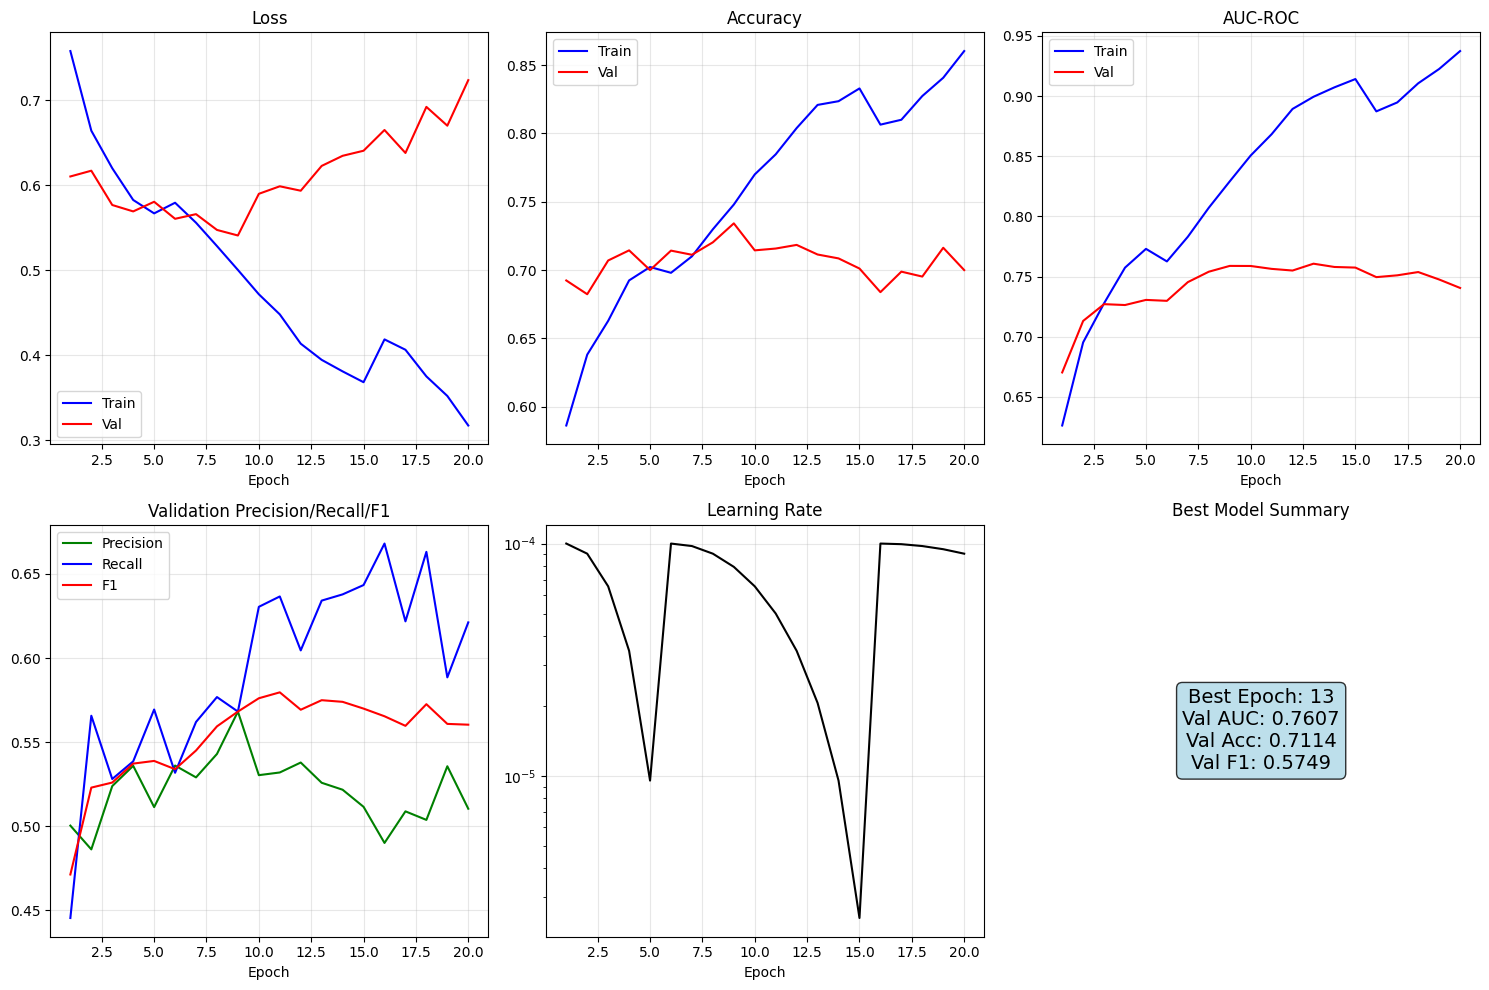


FINAL EVALUATION ON TEST SET


Evaluating: 100%|██████████| 165/165 [12:36<00:00,  4.59s/it]



Test Results:
  Accuracy:    0.7167
  AUC-ROC:     0.7587
  Precision:   0.5328
  Recall:      0.6374
  F1-Score:    0.5804
  Sensitivity: 0.6374
  Specificity: 0.7519

Classification Report:
              precision    recall  f1-score   support

   No DR (0)       0.82      0.75      0.79      3647
  Has DR (1)       0.53      0.64      0.58      1619

    accuracy                           0.72      5266
   macro avg       0.68      0.69      0.68      5266
weighted avg       0.73      0.72      0.72      5266

Confusion Matrix:
[[2742  905]
 [ 587 1032]]


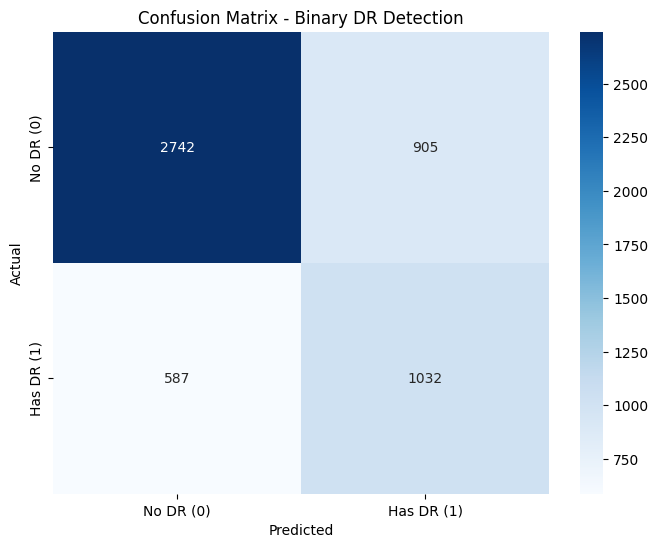

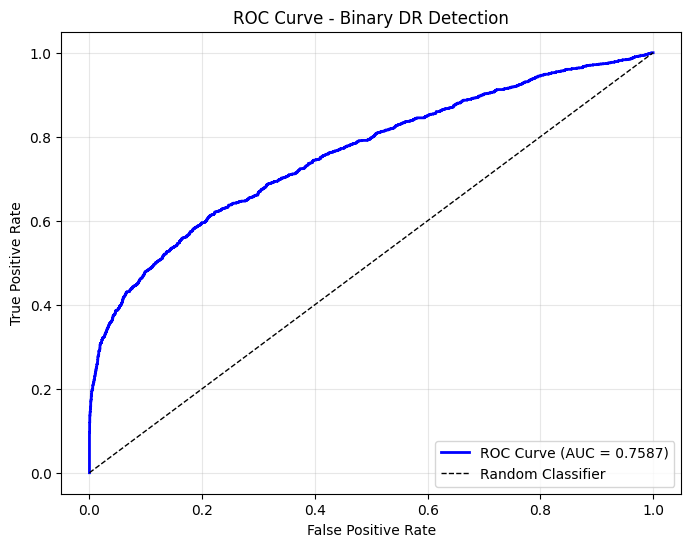


TRAINING AND EVALUATION COMPLETE!

Model saved to: /content/drive/MyDrive/MULTIMODAL/models/efficientnet_b0_binary_dr.pth
Feature dimension for multimodal fusion: 1280

Next step: Use model.extract_features() for multimodal fusion with EHR data.


In [ ]:
"""
EfficientNet-B0 Model for Binary Diabetic Retinopathy Detection
================================================================

This cell defines:
1. EfficientNet-B0 model architecture for binary classification
2. Training and validation functions
3. Metrics tracking (Accuracy, AUC, Precision, Recall, F1)
4. Model checkpointing and early stopping
5. Training visualization

Designed to work with the patient-level preprocessing pipeline from the previous cell.
The model architecture is prepared for later multimodal fusion with EHR data.
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torchvision import models
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import copy
from typing import Dict, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# MODEL CONFIGURATION
# ============================================================================

class ModelConfig:
    """
    Configuration for model training.
    """
    # Model selection
    MODEL_NAME = 'efficientnet_b0'  # Options: 'efficientnet_b0', 'efficientnet_b3', 'resnet34'
    PRETRAINED = True

    # Training hyperparameters
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5

    # Scheduler
    SCHEDULER = 'cosine'  # Options: 'cosine', 'plateau'

    # Early stopping
    PATIENCE = 7
    MIN_DELTA = 0.001

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Checkpointing
    SAVE_DIR = '/content/drive/MyDrive/MULTIMODAL/models'
    MODEL_SAVE_NAME = 'efficientnet_b0_binary_dr.pth'

model_config = ModelConfig()


# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

class BinaryDRClassifier(nn.Module):
    """
    Binary Diabetic Retinopathy Classifier using EfficientNet backbone.

    Architecture:
        - EfficientNet-B0/B3 or ResNet34 backbone (pretrained on ImageNet)
        - Custom classification head for binary output
        - Designed for later fusion with EHR features

    Parameters
    ----------
    model_name : str
        Backbone model name: 'efficientnet_b0', 'efficientnet_b3', 'resnet34'
    pretrained : bool
        Whether to use ImageNet pretrained weights.
    dropout_rate : float
        Dropout rate for regularization.
    """

    def __init__(
        self,
        model_name: str = 'efficientnet_b0',
        pretrained: bool = True,
        dropout_rate: float = 0.3
    ):
        super(BinaryDRClassifier, self).__init__()

        self.model_name = model_name

        # Load backbone
        if model_name == 'efficientnet_b0':
            if pretrained:
                weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
                self.backbone = models.efficientnet_b0(weights=weights)
            else:
                self.backbone = models.efficientnet_b0(weights=None)
            num_features = self.backbone.classifier[1].in_features
            # Remove original classifier
            self.backbone.classifier = nn.Identity()

        elif model_name == 'efficientnet_b3':
            if pretrained:
                weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1
                self.backbone = models.efficientnet_b3(weights=weights)
            else:
                self.backbone = models.efficientnet_b3(weights=None)
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity()

        elif model_name == 'resnet34':
            if pretrained:
                weights = models.ResNet34_Weights.IMAGENET1K_V1
                self.backbone = models.resnet34(weights=weights)
            else:
                self.backbone = models.resnet34(weights=None)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

        else:
            raise ValueError(f"Unknown model: {model_name}")

        # Store feature dimension (useful for multimodal fusion later)
        self.feature_dim = num_features

        # Custom classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        # Initialize classifier weights
        self._init_classifier()

    def _init_classifier(self):
        """Initialize classifier weights using Xavier initialization."""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extract features from backbone (useful for multimodal fusion).

        Parameters
        ----------
        x : torch.Tensor
            Input images of shape (B, 3, H, W).

        Returns
        -------
        torch.Tensor
            Feature vector of shape (B, feature_dim).
        """
        return self.backbone(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Input images of shape (B, 3, H, W).

        Returns
        -------
        torch.Tensor
            Binary predictions of shape (B, 1), values in [0, 1].
        """
        features = self.backbone(x)
        output = self.classifier(features)
        return output


def create_model(config: ModelConfig) -> nn.Module:
    """
    Create and initialize the model.

    Parameters
    ----------
    config : ModelConfig
        Model configuration.

    Returns
    -------
    nn.Module
        Initialized model on the specified device.
    """
    print("=" * 60)
    print("MODEL INITIALIZATION")
    print("=" * 60)

    model = BinaryDRClassifier(
        model_name=config.MODEL_NAME,
        pretrained=config.PRETRAINED,
        dropout_rate=0.3
    )

    model = model.to(config.DEVICE)

    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel: {config.MODEL_NAME}")
    print(f"Pretrained: {config.PRETRAINED}")
    print(f"Feature dimension: {model.feature_dim}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Device: {config.DEVICE}")
    print("=" * 60)

    return model


# ============================================================================
# TRAINING UTILITIES
# ============================================================================

class EarlyStopping:
    """
    Early stopping to prevent overfitting.

    Parameters
    ----------
    patience : int
        Number of epochs to wait before stopping.
    min_delta : float
        Minimum change to qualify as improvement.
    mode : str
        'min' for loss, 'max' for metrics like AUC.
    """

    def __init__(self, patience: int = 7, min_delta: float = 0.001, mode: str = 'max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, score: float, epoch: int) -> bool:
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
        elif self._is_improvement(score):
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def _is_improvement(self, score: float) -> bool:
        if self.mode == 'min':
            return score < self.best_score - self.min_delta
        else:
            return score > self.best_score + self.min_delta


class MetricsTracker:
    """
    Track and store training metrics.
    """

    def __init__(self):
        self.history = {
            'train_loss': [], 'train_acc': [], 'train_auc': [],
            'val_loss': [], 'val_acc': [], 'val_auc': [],
            'val_precision': [], 'val_recall': [], 'val_f1': [],
            'learning_rate': []
        }

    def update(self, metrics: Dict[str, float]):
        for key, value in metrics.items():
            if key in self.history:
                self.history[key].append(value)

    def get_best_metrics(self) -> Dict[str, float]:
        best_idx = np.argmax(self.history['val_auc'])
        return {
            'epoch': best_idx + 1,
            'val_loss': self.history['val_loss'][best_idx],
            'val_acc': self.history['val_acc'][best_idx],
            'val_auc': self.history['val_auc'][best_idx],
            'val_precision': self.history['val_precision'][best_idx],
            'val_recall': self.history['val_recall'][best_idx],
            'val_f1': self.history['val_f1'][best_idx]
        }


# ============================================================================
# TRAINING AND VALIDATION FUNCTIONS
# ============================================================================

def train_one_epoch(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int
) -> Dict[str, float]:
    """
    Train for one epoch.

    Returns
    -------
    dict
        Dictionary with 'loss', 'accuracy', 'auc'.
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)

    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        running_loss += loss.item() * images.size(0)
        all_preds.extend(outputs.detach().cpu().numpy().flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    epoch_acc = accuracy_score(all_labels, (all_preds > 0.5).astype(int))
    epoch_auc = roc_auc_score(all_labels, all_preds)

    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'auc': epoch_auc
    }


def validate(
    model: nn.Module,
    val_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    device: torch.device,
    epoch: int
) -> Tuple[Dict[str, float], np.ndarray, np.ndarray]:
    """
    Validate the model.

    Returns
    -------
    tuple
        (metrics_dict, predictions, labels)
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)

    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_preds_binary = (all_preds > 0.5).astype(int)

    metrics = {
        'loss': epoch_loss,
        'accuracy': accuracy_score(all_labels, all_preds_binary),
        'auc': roc_auc_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds_binary, zero_division=0),
        'recall': recall_score(all_labels, all_preds_binary, zero_division=0),
        'f1': f1_score(all_labels, all_preds_binary, zero_division=0)
    }

    return metrics, all_preds, all_labels


# ============================================================================
# MAIN TRAINING FUNCTION
# ============================================================================

def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    config: ModelConfig
) -> Tuple[nn.Module, MetricsTracker]:
    """
    Complete training loop with validation, early stopping, and checkpointing.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    train_loader : DataLoader
        Training data loader.
    val_loader : DataLoader
        Validation data loader.
    config : ModelConfig
        Training configuration.

    Returns
    -------
    tuple
        (best_model, metrics_tracker)
    """
    print("\n" + "=" * 60)
    print("TRAINING STARTED")
    print("=" * 60)
    print(f"Epochs: {config.NUM_EPOCHS}")
    print(f"Learning Rate: {config.LEARNING_RATE}")
    print(f"Scheduler: {config.SCHEDULER}")
    print(f"Early Stopping Patience: {config.PATIENCE}")
    print("=" * 60 + "\n")

    # Loss function (with class weights for imbalanced data if needed)
    criterion = nn.BCELoss()

    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )

    # Learning rate scheduler
    if config.SCHEDULER == 'cosine':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    else:
        scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

    # Initialize tracking
    metrics_tracker = MetricsTracker()
    early_stopping = EarlyStopping(patience=config.PATIENCE, mode='max')
    best_model_state = None
    best_val_auc = 0.0

    # Create save directory
    import os
    os.makedirs(config.SAVE_DIR, exist_ok=True)

    start_time = time.time()

    for epoch in range(1, config.NUM_EPOCHS + 1):
        print(f"\nEpoch {epoch}/{config.NUM_EPOCHS}")
        print("-" * 40)

        # Train
        train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer, config.DEVICE, epoch
        )

        # Validate
        val_metrics, val_preds, val_labels = validate(
            model, val_loader, criterion, config.DEVICE, epoch
        )

        # Update scheduler
        current_lr = optimizer.param_groups[0]['lr']
        if config.SCHEDULER == 'cosine':
            scheduler.step()
        else:
            scheduler.step(val_metrics['auc'])

        # Track metrics
        metrics_tracker.update({
            'train_loss': train_metrics['loss'],
            'train_acc': train_metrics['accuracy'],
            'train_auc': train_metrics['auc'],
            'val_loss': val_metrics['loss'],
            'val_acc': val_metrics['accuracy'],
            'val_auc': val_metrics['auc'],
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'val_f1': val_metrics['f1'],
            'learning_rate': current_lr
        })

        # Print epoch summary
        print(f"Train | Loss: {train_metrics['loss']:.4f} | "
              f"Acc: {train_metrics['accuracy']:.4f} | "
              f"AUC: {train_metrics['auc']:.4f}")
        print(f"Val   | Loss: {val_metrics['loss']:.4f} | "
              f"Acc: {val_metrics['accuracy']:.4f} | "
              f"AUC: {val_metrics['auc']:.4f}")
        print(f"      | Precision: {val_metrics['precision']:.4f} | "
              f"Recall: {val_metrics['recall']:.4f} | "
              f"F1: {val_metrics['f1']:.4f}")
        print(f"LR: {current_lr:.2e}")

        # Save best model
        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            best_model_state = copy.deepcopy(model.state_dict())

            # Save checkpoint
            checkpoint_path = os.path.join(config.SAVE_DIR, config.MODEL_SAVE_NAME)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc': val_metrics['auc'],
                'val_acc': val_metrics['accuracy'],
                'config': {
                    'model_name': config.MODEL_NAME,
                    'image_size': 224,
                    'feature_dim': model.feature_dim
                }
            }, checkpoint_path)
            print(f"✓ Best model saved! (AUC: {best_val_auc:.4f})")

        # Early stopping check
        if early_stopping(val_metrics['auc'], epoch):
            print(f"\n⚠ Early stopping triggered at epoch {epoch}")
            print(f"  Best epoch: {early_stopping.best_epoch} with AUC: {early_stopping.best_score:.4f}")
            break

    # Training complete
    total_time = time.time() - start_time

    print("\n" + "=" * 60)
    print("TRAINING COMPLETED")
    print("=" * 60)
    print(f"Total time: {total_time/60:.2f} minutes")
    print(f"Best validation AUC: {best_val_auc:.4f}")

    # Load best model state
    model.load_state_dict(best_model_state)

    return model, metrics_tracker


# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device
) -> Dict[str, float]:
    """
    Evaluate model on test set with comprehensive metrics.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    test_loader : DataLoader
        Test data loader.
    device : torch.device
        Device to use.

    Returns
    -------
    dict
        Dictionary containing all evaluation metrics.
    """
    print("\n" + "=" * 60)
    print("FINAL EVALUATION ON TEST SET")
    print("=" * 60)

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_preds_binary = (all_preds > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds_binary),
        'auc': roc_auc_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds_binary),
        'recall': recall_score(all_labels, all_preds_binary),
        'f1': f1_score(all_labels, all_preds_binary),
        'sensitivity': recall_score(all_labels, all_preds_binary),  # Same as recall
        'specificity': recall_score(all_labels, all_preds_binary, pos_label=0)
    }

    # Print results
    print(f"\nTest Results:")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  AUC-ROC:     {metrics['auc']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")
    print(f"  F1-Score:    {metrics['f1']:.4f}")
    print(f"  Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"  Specificity: {metrics['specificity']:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds_binary,
        target_names=['No DR (0)', 'Has DR (1)']
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds_binary)
    print("Confusion Matrix:")
    print(cm)

    return metrics, all_preds, all_labels


# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_training_history(metrics_tracker: MetricsTracker, save_path: str = None):
    """
    Plot training history curves.
    """
    history = metrics_tracker.history
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train')
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # AUC
    axes[0, 2].plot(epochs, history['train_auc'], 'b-', label='Train')
    axes[0, 2].plot(epochs, history['val_auc'], 'r-', label='Val')
    axes[0, 2].set_title('AUC-ROC')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Precision, Recall, F1
    axes[1, 0].plot(epochs, history['val_precision'], 'g-', label='Precision')
    axes[1, 0].plot(epochs, history['val_recall'], 'b-', label='Recall')
    axes[1, 0].plot(epochs, history['val_f1'], 'r-', label='F1')
    axes[1, 0].set_title('Validation Precision/Recall/F1')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 1].plot(epochs, history['learning_rate'], 'k-')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)

    # Best metrics summary
    best = metrics_tracker.get_best_metrics()
    summary_text = (
        f"Best Epoch: {best['epoch']}\n"
        f"Val AUC: {best['val_auc']:.4f}\n"
        f"Val Acc: {best['val_acc']:.4f}\n"
        f"Val F1: {best['val_f1']:.4f}"
    )
    axes[1, 2].text(0.5, 0.5, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=14, verticalalignment='center', horizontalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 2].set_title('Best Model Summary')
    axes[1, 2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Training history saved to {save_path}")

    plt.show()


def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, save_path: str = None):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No DR (0)', 'Has DR (1)'],
                yticklabels=['No DR (0)', 'Has DR (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Binary DR Detection')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


def plot_roc_curve(y_true: np.ndarray, y_pred: np.ndarray, save_path: str = None):
    """
    Plot ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Binary DR Detection')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    """
    Main training execution.

    Prerequisites:
    - Run the previous cell to create train_loader, val_loader, test_loader
    - Ensure Config and ModelConfig are properly set
    """

    # Verify data loaders exist
    try:
        _ = train_loader
        _ = val_loader
        _ = test_loader
        print("[INFO] Data loaders found from previous cell.")
    except NameError:
        raise RuntimeError(
            "Data loaders not found! Please run the preprocessing cell first "
            "to create train_loader, val_loader, and test_loader."
        )

    # Create model
    model = create_model(model_config)

    # Train model
    model, metrics_tracker = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=model_config
    )

    # Plot training history
    plot_training_history(
        metrics_tracker,
        save_path=f"{model_config.SAVE_DIR}/training_history.png"
    )

    # Evaluate on test set
    test_metrics, test_preds, test_labels = evaluate_model(
        model=model,
        test_loader=test_loader,
        device=model_config.DEVICE
    )

    # Plot evaluation results
    plot_confusion_matrix(
        test_labels, test_preds,
        save_path=f"{model_config.SAVE_DIR}/confusion_matrix.png"
    )

    plot_roc_curve(
        test_labels, test_preds,
        save_path=f"{model_config.SAVE_DIR}/roc_curve.png"
    )

    print("\n" + "=" * 60)
    print("TRAINING AND EVALUATION COMPLETE!")
    print("=" * 60)
    print(f"\nModel saved to: {model_config.SAVE_DIR}/{model_config.MODEL_SAVE_NAME}")
    print(f"Feature dimension for multimodal fusion: {model.feature_dim}")
    print("\nNext step: Use model.extract_features() for multimodal fusion with EHR data.")